Epoch 1: Train Loss = 1.1134, Val Loss = 2.6478
Epoch 2: Train Loss = 0.9562, Val Loss = 2.6276
Epoch 3: Train Loss = 0.8506, Val Loss = 2.6499
Epoch 4: Train Loss = 0.7853, Val Loss = 2.6744
Epoch 5: Train Loss = 0.7531, Val Loss = 2.6911
Epoch 6: Train Loss = 0.7511, Val Loss = 2.7043
Epoch 7: Train Loss = 0.7629, Val Loss = 2.7056
Epoch 8: Train Loss = 0.7721, Val Loss = 2.6944
Epoch 9: Train Loss = 0.7693, Val Loss = 2.6699
Epoch 10: Train Loss = 0.7591, Val Loss = 2.6320
Epoch 11: Train Loss = 0.7451, Val Loss = 2.5825
Epoch 12: Train Loss = 0.7309, Val Loss = 2.5252
Epoch 13: Train Loss = 0.7185, Val Loss = 2.4702
Epoch 14: Train Loss = 0.7086, Val Loss = 2.4352
Epoch 15: Train Loss = 0.7012, Val Loss = 2.4324
Epoch 16: Train Loss = 0.6954, Val Loss = 2.4581
Epoch 17: Train Loss = 0.6905, Val Loss = 2.5014
Epoch 18: Train Loss = 0.6860, Val Loss = 2.5565
Epoch 19: Train Loss = 0.6817, Val Loss = 2.6046
Epoch 20: Train Loss = 0.6774, Val Loss = 2.6317
Epoch 21: Train Loss = 0.6725

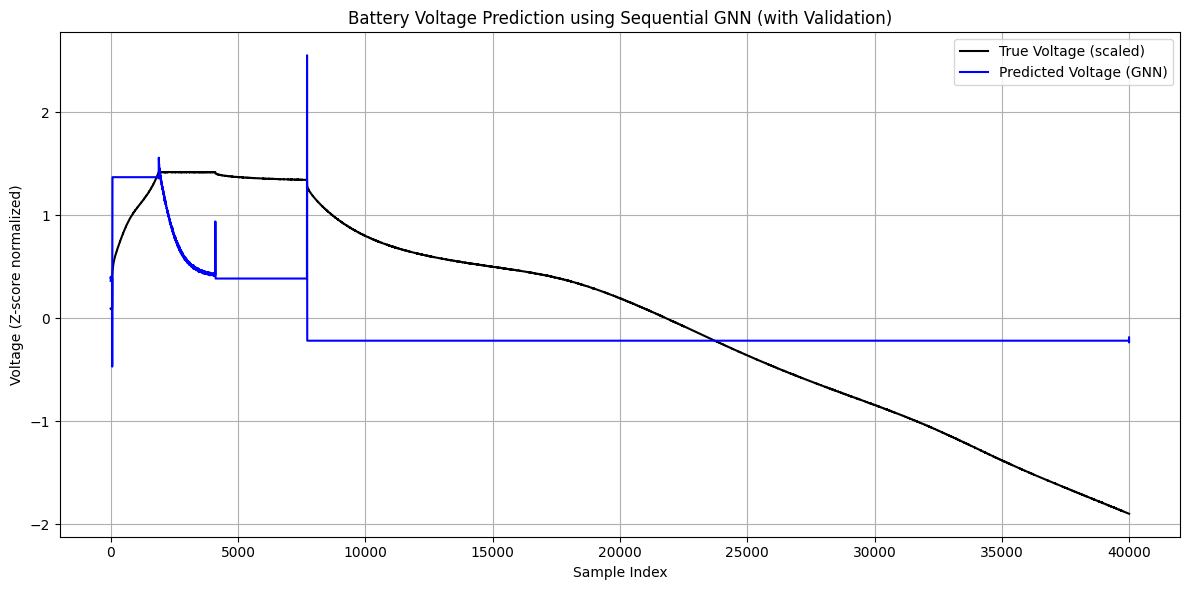

In [51]:
# ------------------- IMPORTS -------------------
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.nn as nn

# ------------------- LOAD DATA -------------------
df = pd.read_csv("/content/Combined_train_Data.csv").iloc[:40000]
I = df['Current_A'].values
V = df['Voltage_V'].values

# ------------------- FEATURE ENGINEERING -------------------
window = 5
I_windowed = np.stack([np.roll(I, i) for i in range(window)], axis=1)
dI_windowed = np.diff(I_windowed, axis=1, prepend=I_windowed[:, [0]])
X = np.concatenate([I_windowed, dI_windowed], axis=1)
X[:window-1, :] = 0  # pad beginning

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(V.reshape(-1, 1)).flatten()

# ------------------- TRAIN / VALIDATION SPLIT -------------------
split_idx = int(0.95 * len(X_scaled))
X_train, X_val = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_val = y_scaled[:split_idx], y_scaled[split_idx:]

# ------------------- GRAPH CONSTRUCTION -------------------
def build_seq_graph(X, y):
    x = torch.tensor(X, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.float)
    edge_index = torch.tensor([[i, i+1] for i in range(len(x)-1)], dtype=torch.long).t()
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
    return Data(x=x, y=y, edge_index=edge_index)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data = build_seq_graph(X_train, y_train).to(device)
val_data = build_seq_graph(X_val, y_val).to(device)

# ------------------- GCN MODEL -------------------
class VoltageGNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, 32)
        self.conv2 = GCNConv(32, 16)
        self.lin = nn.Linear(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.lin(x).squeeze()

model = VoltageGNN(in_dim=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# ------------------- TRAIN WITH EARLY STOPPING -------------------
best_val_loss = float('inf')
patience = 10
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    train_pred = model(train_data)
    train_loss = loss_fn(train_pred, train_data.y)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(val_data)
        val_loss = loss_fn(val_pred, val_data.y)

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    print(f"Epoch {epoch+1}: Train Loss = {train_loss.item():.4f}, Val Loss = {val_loss.item():.4f}")

    # Early stopping
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# ------------------- FINAL EVALUATION -------------------
model.load_state_dict(best_model_state)
model.eval()
with torch.no_grad():
    full_data = build_seq_graph(X_scaled, y_scaled).to(device)
    pred = model(full_data).cpu().numpy()
    true = full_data.y.cpu().numpy()

# ------------------- PLOT -------------------
plt.figure(figsize=(12,6))
plt.plot(true, label='True Voltage (scaled)', color='black')
plt.plot(pred, label='Predicted Voltage (GNN)', color='blue')
plt.title("Battery Voltage Prediction using Sequential GNN (with Validation)")
plt.xlabel("Sample Index")
plt.ylabel("Voltage (Z-score normalized)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
NEW CODE

In [73]:
# ------------------- INSTALL DEPENDENCIES -------------------
# !pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
# !pip install openpyxl

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch.nn as nn
import torch.nn.functional as F

# ------------------- HYPERPARAMETERS -------------------
window = 5
v_delay = 2
learning_rate = 0.005
max_epochs = 300
patience = 10
val_split = 0.05
clip_range = (-4, 4)
smooth_window = 5
dropout_prob = 0.2

# ------------------- LOAD DATA -------------------
df = pd.read_csv("/content/Combined_train_Data.csv")
I = df['Current_A'].values
V = df['Voltage_V'].values

# ------------------- SHARED SCALER FOR INPUT + OUTPUT -------------------
scaler_y = StandardScaler()
V_scaled = scaler_y.fit_transform(V.reshape(-1, 1)).flatten()

# ------------------- FEATURE ENGINEERING -------------------
def make_features(I, V_norm, use_voltage=False):
    I_stack = np.stack([np.roll(I, i) for i in range(window)], axis=1)
    dI_stack = np.diff(I_stack, axis=1, prepend=I_stack[:, [0]])
    features = np.concatenate([I_stack, dI_stack], axis=1)
    if use_voltage:
        V_stack = np.stack([np.roll(V_norm, i) for i in range(1, v_delay + 1)], axis=1)
        features = np.concatenate([features, V_stack], axis=1)
    features[:window-1, :] = 0
    return features

X = make_features(I, V_scaled, use_voltage=True)

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = V_scaled

# ------------------- TRAIN-VALIDATION SPLIT -------------------
split_idx = int((1 - val_split) * len(X_scaled))
X_train, X_val = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_val = y_scaled[:split_idx], y_scaled[split_idx:]

# ------------------- PARAMETRIZED MODEL -------------------
class VoltageGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1=32, hidden_dim2=16, dropout_prob=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.out = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.out(x).squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VoltageGNN(input_dim=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# ------------------- EARLY STOP TRAINING -------------------
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

best_val_loss = float('inf')
wait = 0

for epoch in range(max_epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X_train_tensor)
    train_loss = loss_fn(pred, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_loss = loss_fn(val_pred, y_val_tensor)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss.item():.4f}, Val Loss = {val_loss.item():.4f}")

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_model_state)

# ------------------- CLOSED-LOOP PREDICTION -------------------
model.eval()
with torch.no_grad():
    I_test = df['Current_A'].values[:4000]
    V_true = V[:4000]
    V_scaled_true = scaler_y.transform(V_true.reshape(-1, 1)).flatten()

    V_pred = []
    past_voltages = list(V_scaled_true[:window + v_delay])  # normalized feedback

    for t in range(window + v_delay, len(I_test)):
        I_window = I_test[t-window:t]
        dI_window = np.diff(I_window, prepend=I_window[0])
        input_vector = np.concatenate([I_window, dI_window, past_voltages[-v_delay:]])
        input_scaled = scaler_X.transform(input_vector.reshape(1, -1))
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)

        pred_scaled = model(input_tensor).cpu().item()
        pred_scaled = np.clip(pred_scaled, *clip_range)
        V_pred.append(pred_scaled)
        past_voltages.append(pred_scaled)

# ------------------- SMOOTHING -------------------
def smooth(y, window=5):
    return np.convolve(y, np.ones(window)/window, mode='same')

V_pred_smooth = smooth(V_pred, window=smooth_window)

# ------------------- METRICS -------------------
V_true_eval = V_scaled_true[window + v_delay:window + v_delay + len(V_pred)]
rmse = np.sqrt(mean_squared_error(V_true_eval, V_pred_smooth))
mae = mean_absolute_error(V_true_eval, V_pred_smooth)
r2 = r2_score(V_true_eval, V_pred_smooth)

print(f"\n📊 Closed-Loop GNN Metrics:\nRMSE = {rmse:.4f}, MAE = {mae:.4f}, R² = {r2:.4f}")

# ------------------- PLOT -------------------
plt.figure(figsize=(12, 6))
plt.plot(V_true_eval, label="True Voltage (scaled)", color='black')
plt.plot(V_pred_smooth, label="Predicted Voltage (Closed-Loop GNN, Smoothed)", color='blue')
plt.title("Battery Voltage Prediction (Same Scaler for Input & Target)")
plt.xlabel("Sample Index")
plt.ylabel("Voltage (Z-score normalized)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1: Train Loss = 1.0091, Val Loss = 0.9077
Epoch 2: Train Loss = 0.9642, Val Loss = 0.8458
Epoch 3: Train Loss = 0.9173, Val Loss = 0.7741
Epoch 4: Train Loss = 0.8687, Val Loss = 0.6975
Epoch 5: Train Loss = 0.8168, Val Loss = 0.6179
Epoch 6: Train Loss = 0.7633, Val Loss = 0.5363
Epoch 7: Train Loss = 0.7080, Val Loss = 0.4534
Epoch 8: Train Loss = 0.6529, Val Loss = 0.3715
Epoch 9: Train Loss = 0.5983, Val Loss = 0.2941
Epoch 10: Train Loss = 0.5450, Val Loss = 0.2252
Epoch 11: Train Loss = 0.4932, Val Loss = 0.1666
Epoch 12: Train Loss = 0.4420, Val Loss = 0.1180
Epoch 13: Train Loss = 0.3911, Val Loss = 0.0791
Epoch 14: Train Loss = 0.3408, Val Loss = 0.0494
Epoch 15: Train Loss = 0.2916, Val Loss = 0.0282
Epoch 16: Train Loss = 0.2446, Val Loss = 0.0155
Epoch 17: Train Loss = 0.2016, Val Loss = 0.0103
Epoch 18: Train Loss = 0.1638, Val Loss = 0.0107
Epoch 19: Train Loss = 0.1320, Val Loss = 0.0148
Epoch 20: Train Loss = 0.1096, Val Loss = 0.0221
Epoch 21: Train Loss = 0.0960

KeyboardInterrupt: 

In [ ]:
# GRUS

In [82]:
# ------------------- INSTALL DEPENDENCIES -------------------
# !pip install openpyxl

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch.nn as nn
import random

# ------------------- HYPERPARAMETERS -------------------
window = 10
v_delay = 2
hidden_size = 64
learning_rate = 0.005
max_epochs = 300
patience = 15
val_split = 0.05
smooth_window = 5
clip_range = (-4, 4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Scheduled sampling config
start_sampling_prob = 0.0
end_sampling_prob = 1.0
sampling_ramp_epochs = 100

# ------------------- LOAD DATA -------------------
df = pd.read_csv("/content/Combined_train_Data.csv").iloc[:50000]  # use only first 5000 rows
I = df['Current_A'].values
V = df['Voltage_V'].values

# ------------------- SCALING -------------------
scaler_y = StandardScaler()
V_scaled = scaler_y.fit_transform(V.reshape(-1, 1)).flatten()

def create_sequence_data(I, V_scaled, window, v_delay):
    X = []
    y = []
    for t in range(window + v_delay, len(I)):
        I_window = I[t-window:t]
        dI_window = np.diff(I_window, prepend=I_window[0])
        V_window = V_scaled[t-v_delay:t]
        features = np.concatenate([I_window, dI_window, V_window])
        target = V_scaled[t]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y)

X_raw, y = create_sequence_data(I, V_scaled, window, v_delay)
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
X_scaled_seq = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# ------------------- SPLIT -------------------
split_idx = int((1 - val_split) * len(X_scaled_seq))
X_train, X_val = X_scaled_seq[:split_idx], X_scaled_seq[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

# ------------------- MODEL -------------------
class GRUNARX(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1]).squeeze()

model = GRUNARX(input_dim=X_scaled_seq.shape[2], hidden_size=hidden_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# ------------------- TRAIN WITH SCHEDULED SAMPLING -------------------
X_train_raw = X_raw[:split_idx]
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

best_val_loss = float('inf')
wait = 0

for epoch in range(max_epochs):
    model.train()
    preds = []
    targets = []

    sampling_prob = min(end_sampling_prob, start_sampling_prob + (epoch / sampling_ramp_epochs) * (end_sampling_prob - start_sampling_prob))

    for i in range(len(X_train_raw)):
        input_feat = X_train_raw[i].copy()

        # Scheduled sampling: replace some voltage feedback with past model prediction
        for v_idx in range(-v_delay, 0):
            if random.random() < sampling_prob and len(preds) > 0:
                input_feat[v_idx] = preds[-1].detach()  # use last model prediction

        input_scaled = scaler_X.transform(input_feat.reshape(1, -1)).reshape(1, 1, -1)
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)
        target = torch.tensor(y_train[i], dtype=torch.float32).to(device)

        pred = model(input_tensor)
        preds.append(pred)
        targets.append(target)

    preds_tensor = torch.stack(preds)
    targets_tensor = torch.stack(targets)
    loss = loss_fn(preds_tensor, targets_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_loss = loss_fn(val_pred, y_val_tensor)

    print(f"Epoch {epoch+1}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}, Sampling Prob = {sampling_prob:.2f}")

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_model_state)



Epoch 1: Train Loss = 0.8504, Val Loss = 2.3063, Sampling Prob = 0.00
Epoch 2: Train Loss = 0.7423, Val Loss = 2.1315, Sampling Prob = 0.01
Epoch 3: Train Loss = 0.6540, Val Loss = 1.9587, Sampling Prob = 0.02
Epoch 4: Train Loss = 0.5846, Val Loss = 1.7876, Sampling Prob = 0.03
Epoch 5: Train Loss = 0.5316, Val Loss = 1.6186, Sampling Prob = 0.04
Epoch 6: Train Loss = 0.4888, Val Loss = 1.4541, Sampling Prob = 0.05
Epoch 7: Train Loss = 0.4491, Val Loss = 1.2967, Sampling Prob = 0.06
Epoch 8: Train Loss = 0.4106, Val Loss = 1.1478, Sampling Prob = 0.07
Epoch 9: Train Loss = 0.3696, Val Loss = 1.0078, Sampling Prob = 0.08
Epoch 10: Train Loss = 0.3269, Val Loss = 0.8763, Sampling Prob = 0.09
Epoch 11: Train Loss = 0.2832, Val Loss = 0.7529, Sampling Prob = 0.10
Epoch 12: Train Loss = 0.2407, Val Loss = 0.6366, Sampling Prob = 0.11
Epoch 13: Train Loss = 0.1995, Val Loss = 0.5269, Sampling Prob = 0.12
Epoch 14: Train Loss = 0.1613, Val Loss = 0.4234, Sampling Prob = 0.13
Epoch 15: Train

<All keys matched successfully>


📊 GRU with Scheduled Sampling Metrics:
RMSE = 0.8672, MAE = 0.6208, R² = -0.2820


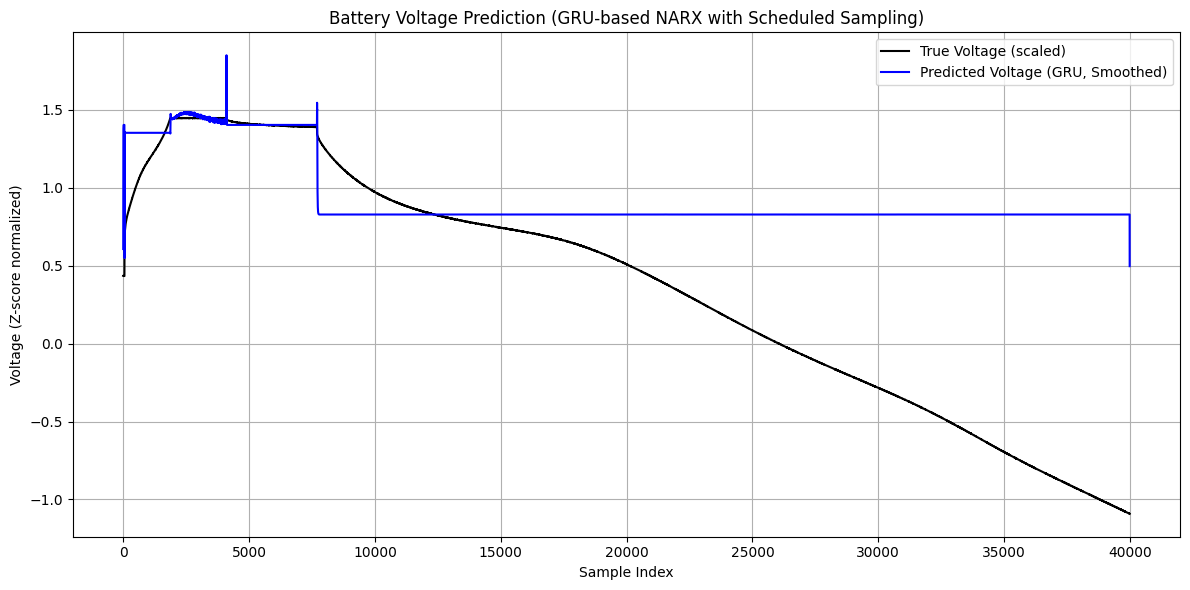

In [83]:
# ------------------- CLOSED-LOOP PREDICTION -------------------
model.eval()
I_test = df['Current_A'].values[:40000]
V_true = V[:40000]
V_scaled_true = scaler_y.transform(V_true.reshape(-1, 1)).flatten()

V_pred = []
past_voltages = list(V_scaled_true[:window + v_delay])  # bootstrap

for t in range(window + v_delay, len(I_test)):
    I_window = I_test[t - window:t]
    dI_window = np.diff(I_window, prepend=I_window[0])
    V_window = past_voltages[-v_delay:]
    input_vector = np.concatenate([I_window, dI_window, V_window])
    input_scaled = scaler_X.transform(input_vector.reshape(1, -1))
    input_seq = torch.tensor(input_scaled.reshape(1, 1, -1), dtype=torch.float32).to(device)

    with torch.no_grad():
        pred_scaled = model(input_seq).cpu().item()
        pred_scaled = np.clip(pred_scaled, *clip_range)
        V_pred.append(pred_scaled)
        past_voltages.append(pred_scaled)

# ------------------- SMOOTHING -------------------
def smooth(y, window=5):
    return np.convolve(y, np.ones(window)/window, mode='same')

V_pred_smooth = smooth(V_pred, window=smooth_window)

# ------------------- METRICS -------------------
V_true_eval = V_scaled_true[window + v_delay:window + v_delay + len(V_pred)]
rmse = np.sqrt(mean_squared_error(V_true_eval, V_pred_smooth))
mae = mean_absolute_error(V_true_eval, V_pred_smooth)
r2 = r2_score(V_true_eval, V_pred_smooth)
print(f"\n📊 GRU with Scheduled Sampling Metrics:\nRMSE = {rmse:.4f}, MAE = {mae:.4f}, R² = {r2:.4f}")

# ------------------- PLOT -------------------
plt.figure(figsize=(12, 6))
plt.plot(V_true_eval, label="True Voltage (scaled)", color='black')
plt.plot(V_pred_smooth, label="Predicted Voltage (GRU, Smoothed)", color='blue')
plt.title("Battery Voltage Prediction (GRU-based NARX with Scheduled Sampling)")
plt.xlabel("Sample Index")
plt.ylabel("Voltage (Z-score normalized)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [40]:
!pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install openpyxl

# ------------------- IMPORTS -------------------
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F

# ------------------- LOAD TRAINING DATA -------------------
train_df = pd.read_csv("/content/Combined_train_Data.csv").iloc[:]
I_train = train_df['Current_A'].values
V_train = train_df['Voltage_V'].values

# ------------------- LOAD TEST DATA -------------------
test_df = pd.read_excel("/content/Merged_test_Data.xlsx", engine="openpyxl")
I_test = test_df['Current_A'].values
V_test = test_df['Voltage_V'].values

# ------------------- FEATURE ENGINEERING -------------------
def window_and_diff(I, window):
    I_windowed = np.stack([np.roll(I, i) for i in range(window)], axis=1)
    dI_windowed = np.diff(I_windowed, axis=1, prepend=I_windowed[:, [0]])
    X = np.concatenate([I_windowed, dI_windowed], axis=1)
    X[:window-1, :] = 0  # pad first few rows
    return X

window = 5
X_train = window_and_diff(I_train, window)
X_test = window_and_diff(I_test, window)

# ------------------- NORMALIZATION -------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(V_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(V_test.reshape(-1, 1)).flatten()


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html


In [41]:
# ------------------- BUILD GRAPH -------------------
def build_seq_graph(X, y):
    x = torch.tensor(X, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.float)
    edge_index = torch.tensor([[i, i+1] for i in range(len(x)-1)], dtype=torch.long).t()
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
    return Data(x=x, y=y, edge_index=edge_index)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data = build_seq_graph(X_train_scaled, y_train_scaled).to(device)
test_data = build_seq_graph(X_test_scaled, y_test_scaled).to(device)

In [42]:
# ------------------- Feature Extractor -------------------
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(window, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )
    def forward(self, x):
        return self.net(x)

# ------------------- GP Model -------------------
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, feature_extractor):
        super().__init__(train_x, train_y, likelihood)
        self.feature_extractor = feature_extractor
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        x = self.feature_extractor(x)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [43]:
# ------------------- GNN MODEL -------------------
class VoltageGNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, 32)
        self.conv2 = GCNConv(32, 16)
        self.lin = nn.Linear(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.lin(x).squeeze()


In [44]:

model = VoltageGNN(in_dim=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# ------------------- TRAIN -------------------
model.train()
for epoch in range(1000):
    optimizer.zero_grad()
    pred = model(train_data)
    loss = loss_fn(pred, train_data.y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}: Train Loss = {loss.item():.4f}")


Epoch 1: Train Loss = 1.0053
Epoch 2: Train Loss = 0.9685
Epoch 3: Train Loss = 0.9577
Epoch 4: Train Loss = 0.9528
Epoch 5: Train Loss = 0.9491
Epoch 6: Train Loss = 0.9466
Epoch 7: Train Loss = 0.9426
Epoch 8: Train Loss = 0.9378
Epoch 9: Train Loss = 0.9328
Epoch 10: Train Loss = 0.9270
Epoch 11: Train Loss = 0.9211
Epoch 12: Train Loss = 0.9151
Epoch 13: Train Loss = 0.9085
Epoch 14: Train Loss = 0.9022
Epoch 15: Train Loss = 0.8961
Epoch 16: Train Loss = 0.8904
Epoch 17: Train Loss = 0.8860
Epoch 18: Train Loss = 0.8830
Epoch 19: Train Loss = 0.8824
Epoch 20: Train Loss = 0.8822
Epoch 21: Train Loss = 0.8819
Epoch 22: Train Loss = 0.8809
Epoch 23: Train Loss = 0.8790
Epoch 24: Train Loss = 0.8771
Epoch 25: Train Loss = 0.8746
Epoch 26: Train Loss = 0.8719
Epoch 27: Train Loss = 0.8698
Epoch 28: Train Loss = 0.8680
Epoch 29: Train Loss = 0.8658
Epoch 30: Train Loss = 0.8643
Epoch 31: Train Loss = 0.8632
Epoch 32: Train Loss = 0.8626
Epoch 33: Train Loss = 0.8611
Epoch 34: Train Los


📊 Test Performance:
RMSE: 1.3715658217463986
MAE : 1.2021965980529785
R²  : -8.768792152404785


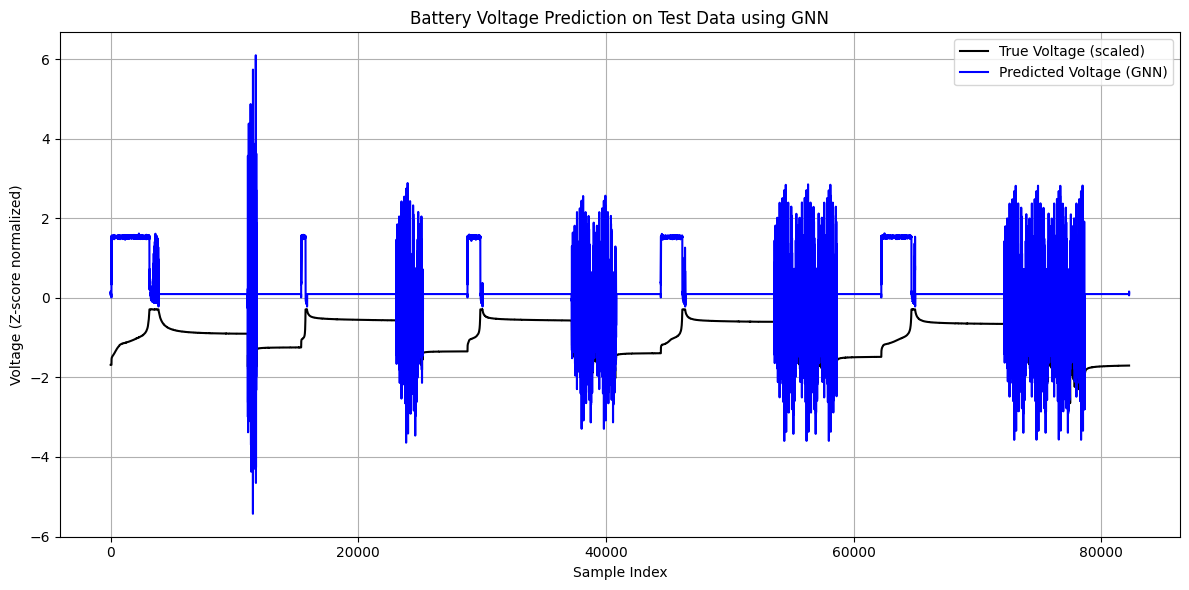

In [46]:
# ------------------- EVALUATE ON TEST DATA -------------------
model.eval()
with torch.no_grad():
    test_pred = model(test_data).cpu().numpy()
    test_true = test_data.y.cpu().numpy()

# ------------------- METRICS -------------------
print("\n📊 Test Performance:")
print("RMSE:", np.sqrt(mean_squared_error(test_true, test_pred)))
print("MAE :", mean_absolute_error(test_true, test_pred))
print("R²  :", r2_score(test_true, test_pred))

# ------------------- PLOT -------------------
plt.figure(figsize=(12,6))
plt.plot(test_true, label='True Voltage (scaled)', color='black')
plt.plot(test_pred, label='Predicted Voltage (GNN)', color='blue')
plt.title("Battery Voltage Prediction on Test Data using GNN")
plt.xlabel("Sample Index")
plt.ylabel("Voltage (Z-score normalized)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1: Loss = 0.9396
Epoch 2: Loss = 0.8265
Epoch 3: Loss = 0.7256
Epoch 4: Loss = 0.6662
Epoch 5: Loss = 0.6754
Epoch 6: Loss = 0.6827
Epoch 7: Loss = 0.6627
Epoch 8: Loss = 0.6468
Epoch 9: Loss = 0.6485
Epoch 10: Loss = 0.6441
Epoch 11: Loss = 0.6279
Epoch 12: Loss = 0.6149
Epoch 13: Loss = 0.6134
Epoch 14: Loss = 0.6182
Epoch 15: Loss = 0.6162
Epoch 16: Loss = 0.6057
Epoch 17: Loss = 0.5951
Epoch 18: Loss = 0.5910
Epoch 19: Loss = 0.5910
Epoch 20: Loss = 0.5844
Epoch 21: Loss = 0.5729
Epoch 22: Loss = 0.5681
Epoch 23: Loss = 0.5666
Epoch 24: Loss = 0.5558
Epoch 25: Loss = 0.5447
Epoch 26: Loss = 0.5442
Epoch 27: Loss = 0.5333
Epoch 28: Loss = 0.5196
Epoch 29: Loss = 0.5075
Epoch 30: Loss = 0.4813
Epoch 31: Loss = 0.4547
Epoch 32: Loss = 0.4091
Epoch 33: Loss = 0.3668
Epoch 34: Loss = 0.3281
Epoch 35: Loss = 0.3082
Epoch 36: Loss = 0.3092
Epoch 37: Loss = 0.3196
Epoch 38: Loss = 0.3781
Epoch 39: Loss = 0.3608
Epoch 40: Loss = 0.2928
Epoch 41: Loss = 0.3338
Epoch 42: Loss = 0.2935
E

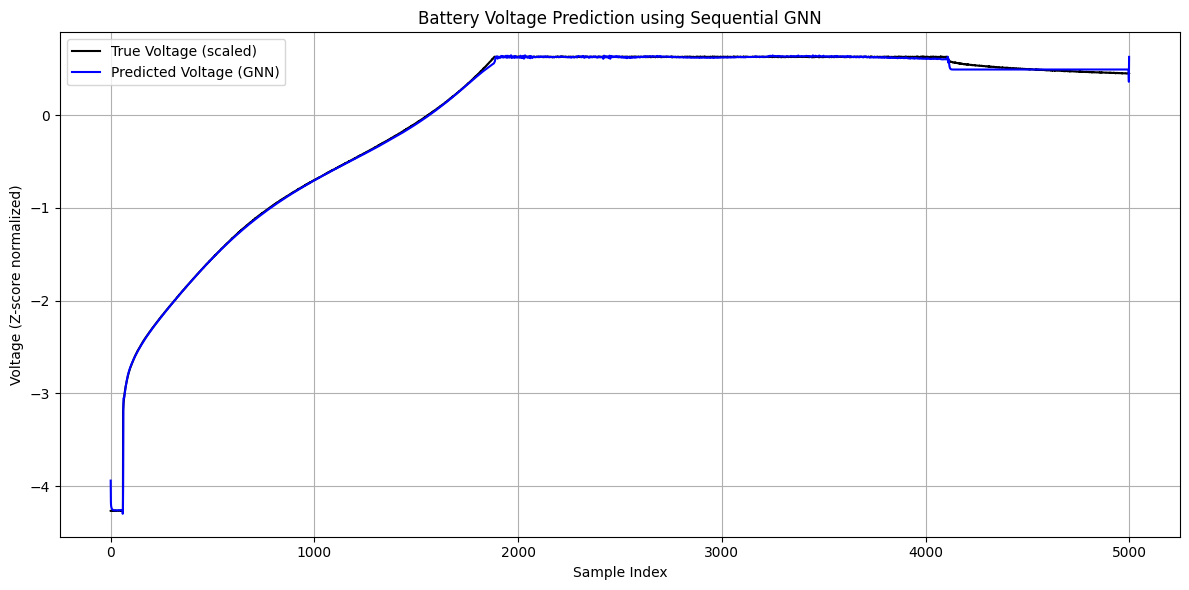

In [25]:
# ------------------- IMPORTS -------------------
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

# ------------------- LOAD DATA -------------------
df = pd.read_csv("/content/Combined_train_Data.csv").iloc[:5000]
I = df['Current_A'].values
V = df['Voltage_V'].values

# ------------------- FEATURE ENGINEERING -------------------
window = 5
I_windowed = np.stack([np.roll(I, i) for i in range(window)], axis=1)
dI_windowed = np.diff(I_windowed, axis=1, prepend=I_windowed[:, [0]])
X = np.concatenate([I_windowed, dI_windowed], axis=1)
X[:window-1, :] = 0  # pad beginning

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(V.reshape(-1, 1)).flatten()

# ------------------- BUILD SEQUENTIAL GRAPH -------------------
x = torch.tensor(X_scaled, dtype=torch.float)
y = torch.tensor(y_scaled, dtype=torch.float)
edge_index = torch.tensor([[i, i+1] for i in range(len(x)-1)], dtype=torch.long).t()
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # bidirectional

data = Data(x=x, y=y, edge_index=edge_index).to('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------- GCN MODEL -------------------
class VoltageGNN(torch.nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, 32)
        self.conv2 = GCNConv(32, 16)
        self.gru = torch.nn.GRU(16, 16, batch_first=True)
        self.lin = torch.nn.Linear(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x_seq = x.unsqueeze(0)  # GRU expects (batch, seq, features)
        x_gru, _ = self.gru(x_seq)
        x_out = self.lin(x_gru.squeeze(0))
        return x_out.squeeze()


model = VoltageGNN(in_dim=X.shape[1]).to(data.x.device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

# ------------------- TRAIN -------------------
model.train()
for epoch in range(1000):
    optimizer.zero_grad()
    pred = model(data)
    loss = loss_fn(pred, data.y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

# ------------------- EVALUATE -------------------
model.eval()
with torch.no_grad():
    pred = model(data).cpu().numpy()
    true = data.y.cpu().numpy()

# ------------------- PLOT -------------------
plt.figure(figsize=(12,6))
plt.plot(true, label='True Voltage (scaled)', color='black')
plt.plot(pred, label='Predicted Voltage (GNN)', color='blue')
plt.title("Battery Voltage Prediction using Sequential GNN")
plt.xlabel("Sample Index")
plt.ylabel("Voltage (Z-score normalized)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
test_data = build_seq_graph(X_test_scaled, y_test_scaled).to(device)

# ------------------- EVALUATE ON TEST DATA -------------------
model.eval()
with torch.no_grad():
    test_pred = model(test_data).cpu().numpy()
    test_true = test_data.y.cpu().numpy()

# ------------------- METRICS -------------------
print("\n📊 Test Performance:")
print("RMSE:", np.sqrt(mean_squared_error(test_true, test_pred)))
print("MAE :", mean_absolute_error(test_true, test_pred))
print("R²  :", r2_score(test_true, test_pred))

# ------------------- PLOT -------------------
plt.figure(figsize=(12,6))
plt.plot(test_true, label='True Voltage (scaled)', color='black')
plt.plot(test_pred, label='Predicted Voltage (GNN)', color='blue')
plt.title("Battery Voltage Prediction on Test Data using GNN")
plt.xlabel("Sample Index")
plt.ylabel("Voltage (Z-score normalized)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'build_seq_graph' is not defined